# 2. PyTorch Dataset and DataLoader

**Objective:** This notebook prepares the deepfake face dataset for model training.

We will:
1.  Create a custom PyTorch `Dataset` class to load images and labels.
2.  Define data augmentation and normalization transforms for training and validation.
3.  Split the data into training and validation sets in a stratified manner to preserve the class imbalance ratio.
4.  Create PyTorch `DataLoaders` to efficiently feed data to the model in batches.
5.  Visualize a batch of training data to ensure the augmentations are working correctly.

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Configuration ---
DATA_DIR = os.path.join("..", "data")
METADATA_PATH = os.path.join(DATA_DIR, "faces_metadata.csv")
IMAGE_DIR = os.path.join(DATA_DIR, "frames_cropped_full")

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
RANDOM_STATE = 42

## 1. Create Custom PyTorch Dataset

We'll define a class that inherits from `torch.utils.data.Dataset`. This requires implementing three methods:
*   `__init__()`: To initialize the dataset, load the metadata, and set up transforms.
*   `__len__()`: To return the total number of samples in the dataset.
*   `__getitem__()`: To load and return one sample (image and label) at a given index.

In [6]:
class DeepfakeFaceDataset(Dataset):
    """Custom Dataset for loading deepfake face images."""
    def __init__(self, metadata_df, root_dir, transform=None):
        """
        Args:
            metadata_df (pd.DataFrame): DataFrame with image filenames and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata_df = metadata_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.metadata_df.iloc[idx, 0])
        # Albumentations works with NumPy arrays, so we use cv2 to load the image
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = int(self.metadata_df.iloc[idx, 1])

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

## 2. Define Data Augmentation and Transforms

Data augmentation is crucial for preventing overfitting and helping the model generalize better. We'll apply more aggressive augmentations to the training set and only basic normalization to the validation set.

The normalization values `(0.5, 0.5, 0.5)` are a common starting point for transfer learning with models pretrained on ImageNet. They scale images to the range `[-1, 1]`.

In [13]:
# data_transforms = {
#     'train': A.Compose([
#         A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
#         A.HorizontalFlip(p=0.5),
#         A.Rotate(limit=10, p=0.5),
#         A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#         ToTensorV2()
#     ]),
#     'val': A.Compose([
#         A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#         ToTensorV2()
#     ]),
# }

# Using Albumentations for more powerful and diverse augmentations
data_transforms = {
    'train': A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        # Add more robust augmentations
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.2),
        # This augmentation is very relevant for deepfake detection
        A.OneOf([
            A.ImageCompression(quality_range=(70, 90), p=0.5),
            A.Blur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(), # Use the ToTensorV2 from Albumentations
    ]),
    'val': A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ]),
}

## 3. Split Data into Training and Validation Sets

We need to split our dataset so we can evaluate our model's performance on unseen data. It's important to use **stratified splitting** to ensure that the train and validation sets have the same proportion of real and fake images as the original dataset.

In [14]:
df = pd.read_csv(METADATA_PATH)

# Get labels for stratification
labels = df['label']

# Split the DataFrame
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=labels
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

print("\nOriginal class distribution:")
print(df['label'].value_counts(normalize=True))

print("\nTraining class distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation class distribution:")
print(val_df['label'].value_counts(normalize=True))

Total samples: 155711
Training samples: 124568
Validation samples: 31143

Original class distribution:
label
1    0.783066
0    0.216934
Name: proportion, dtype: float64

Training class distribution:
label
1    0.783066
0    0.216934
Name: proportion, dtype: float64

Validation class distribution:
label
1    0.783065
0    0.216935
Name: proportion, dtype: float64


## 4. Create Datasets and DataLoaders

Now we can instantiate our custom `Dataset` for both training and validation sets, applying the appropriate transforms. Then, we wrap them in `DataLoader`s.

In [15]:
train_dataset = DeepfakeFaceDataset(
    metadata_df=train_df.reset_index(drop=True), 
    root_dir=IMAGE_DIR, 
    transform=data_transforms['train']
)

val_dataset = DeepfakeFaceDataset(
    metadata_df=val_df.reset_index(drop=True), 
    root_dir=IMAGE_DIR, 
    transform=data_transforms['val']
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Set to 0 for faster notebook interaction
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # Set to 0 for faster notebook interaction

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Created {len(train_loader)} training batches of size {BATCH_SIZE}")
print(f"Created {len(val_loader)} validation batches of size {BATCH_SIZE}")

Created 3893 training batches of size 32
Created 974 validation batches of size 32


## 5. Visualize a Batch of Training Data

This is a final sanity check to see what our model will actually be "seeing". We'll grab one batch from the `train_loader` and display the images. Notice the effects of the random augmentations (flips, rotations, color changes). The colors may look strange because we've normalized the pixel values.

Labels for first row:  ['FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE']


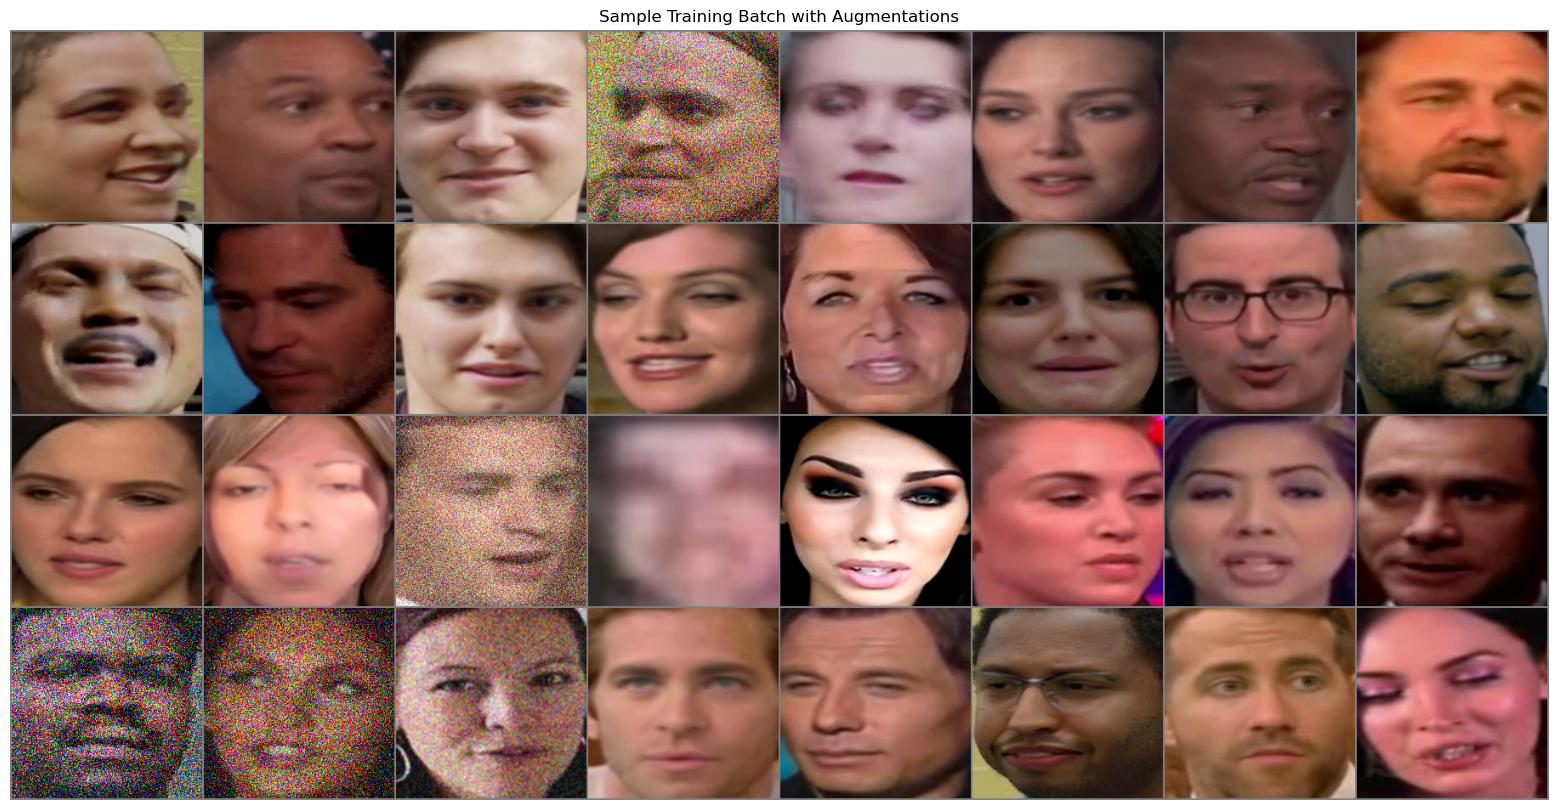

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Denormalize
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

class_names = {0: 'REAL', 1: 'FAKE'}
class_titles = [class_names[x.item()] for x in classes]

plt.figure(figsize=(20, 10))
imshow(out, title='Sample Training Batch with Augmentations')
print("Labels for first row: ", class_titles[:8])

## Next Steps

With our `DataLoaders` ready, we have everything we need to start training a model. The next notebook will focus on:

1.  Loading a pretrained model (like XceptionNet).
2.  Defining the loss function (with class weights) and optimizer.
3.  Writing the training and validation loop.